# Spotlight on Synergy: Crafting a Recommendation System for Spotify Artist Collaborations Through Network Analysis

In this notebook, we delve into the vibrant world of Spotify, with the aim of designing a recommendation system for artist feature collaborations using network analysis. By constructing a network graph where artists are nodes connected by their past collaborations, we seek to unearth new collaborative opportunities hidden within Spotify's extensive music catalog.

Our analysis leverages network metrics to highlight promising connections between artists, thereby facilitating innovative musical partnerships. This project not only promises to empower artists with data-driven insights for their next collaborative projects but also aims to enrich the Spotify experience by fostering fresh and innovative musical pairings.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.cm import ScalarMappable
import scipy as sp
# import nxviz as nv
from itertools import combinations
from collections import defaultdict
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spotify-artist-feature-collaboration-network/nodes.csv
/kaggle/input/spotify-artist-feature-collaboration-network/edges.csv


In [2]:
# edges.csv contains features between artists in nodes.csv, identified by their spotify_ids
edges = pd.read_csv('/kaggle/input/spotify-artist-feature-collaboration-network/edges.csv')
print(edges.shape)
edges.head()

(300386, 2)


,id_0,id_1
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
3,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
4,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0


In [3]:
# nodes.csv contains various artist informations
nodes = pd.read_csv('/kaggle/input/spotify-artist-feature-collaboration-network/nodes.csv')
print(nodes.shape)
nodes.head()

(156422, 6)


,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"['nordic house', 'russelater']",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']"
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)']


In [4]:
# We'll have to filter out some rows in nodes, as most of it relates to unpopular artists
nodes.describe()

,followers,popularity
count,1.564180e+05,156422.000000
mean,8.622371e+04,21.157497
std,9.401001e+05,18.338290
min,0.000000e+00,0.000000
25%,2.400000e+01,4.000000
50%,3.630000e+02,18.000000
75%,6.258000e+03,34.000000
max,1.021569e+08,100.000000


In [5]:
# Let's keep only the top 1% popular artists
nodes = nodes.loc[nodes['popularity'] >= nodes['popularity'].quantile(0.99)]

In [6]:
# Some missing values in chart hits... well not everybody can make hits!
print(edges.isna().sum())
print(nodes.isna().sum())

id_0    0
id_1    0
dtype: int64
spotify_id      0
name            0
followers       0
popularity      0
genres          0
chart_hits    168
dtype: int64


In [7]:
# Time to build our first graph, let's replace artists ids by their names for readability
nodes = nodes.dropna(subset=['name', 'followers'])

id_to_name = dict(zip(nodes['spotify_id'], nodes['name']))

edges['id_0'] = edges['id_0'].map(id_to_name)
edges['id_1'] = edges['id_1'].map(id_to_name)

# We should rename columns, and we get our main graph!
edges.rename(columns={'id_0': 'source', 'id_1': 'target'}, inplace=True)
 
G = nx.from_pandas_edgelist(edges, 'source', 'target')

In [8]:
def add_metadata_to_nodes(graph, nodes_data, metadata_columns=['followers', 'popularity', 'genres', 'chart_hits']):
    """
    Add metadata attributes to nodes in the graph based on provided nodes_data DataFrame.
    """
    for node_id in graph.nodes():
        if node_id in nodes_data['name'].values:
            metadata = nodes_data.loc[nodes_data['name'] == node_id, metadata_columns].to_dict('records')[0]
            # Replace missing values in chart_hits by 0
            if pd.isnull(metadata['chart_hits']):
                metadata['chart_hits'] = 0 
            graph.nodes[node_id].update(metadata)
        else:
            print(f"No match found for artist: {node_id}")
    return graph

G = add_metadata_to_nodes(G, nodes)

No match found for artist: nan


In [9]:
print(G)

Graph with 1654 nodes and 14254 edges


In [10]:
# To ease our analysis, we'll work on a subgraph with rows above the 0.75 quantile on popularity
top_01 = list(nodes['name'].loc[nodes['popularity']>=nodes['popularity'].quantile(0.75)])
H = G.subgraph(top_01).copy()

In [11]:
print(H)

Graph with 477 nodes and 3959 edges


False


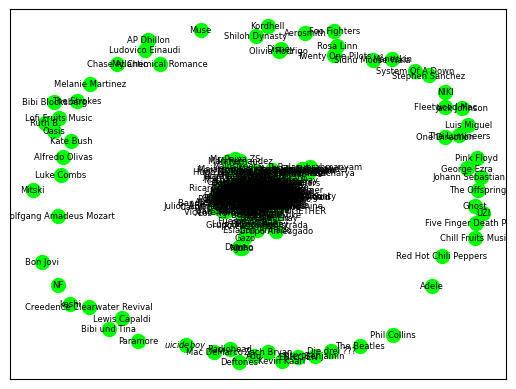

In [12]:
# For the purpose of this project, we need our subgraph to be connected
print(nx.is_connected(H))
nx.draw_networkx(H, node_color='lime', node_size=100, font_size=6)

In [13]:
Hc = H.subgraph(max(nx.connected_components(H), key=len)).copy()
print(Hc)

Graph with 414 nodes and 3958 edges


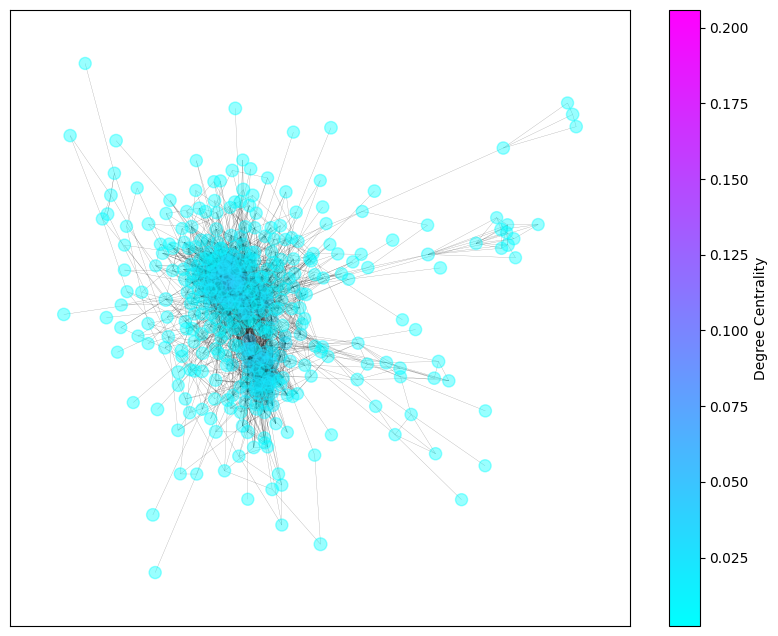

In [14]:
def plot_network_graph_with_degree_centrality(graph, with_labels=False, alpha=0.7, width=0.3, font_size=6):
    """
    Plot a network graph with node sizes based on 'popularity' attribute and colors based on degree centrality.

    Parameters:
        graph (networkx.Graph): The graph to be plotted.

    Returns:
        None
    """
    degree_centrality = nx.degree_centrality(graph)

    colormap = plt.cm.cool
    sm = ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min(degree_centrality.values()), vmax=max(degree_centrality.values())))

    colors = {}
    for node, centrality in degree_centrality.items():
        color = colormap(centrality)
        colors[node] = color

    sizes = nx.get_node_attributes(graph, 'popularity')

    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    nx.draw_networkx(graph, node_size=list(sizes.values()), with_labels=with_labels, node_color=list(colors.values()), ax=ax, alpha=alpha, width=width, font_size=font_size)

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Degree Centrality')

    plt.show()

plot_network_graph_with_degree_centrality(Hc, alpha=0.4, width=0.2)


In [15]:
# How centrality measures are correlated ?
measures = [nx.eigenvector_centrality(Hc), 
            nx.betweenness_centrality(Hc), 
            nx.degree_centrality(Hc)]

cor = pd.DataFrame.from_records(measures)

cor.T.corr()

,0,1,2
0,1.000000,0.523635,0.970964
1,0.523635,1.000000,0.644373
2,0.970964,0.644373,1.000000


In [16]:
# Let's find out who are the most central artists in the network
e_cent, b_cent, d_cent = cor.T.idxmax()

print(e_cent, b_cent, d_cent)

Future J Balvin J Balvin


In [17]:
print('J Balvin has collaborated with {} artists in our subgraph'
      .format(len(list(Hc.neighbors('J Balvin')))))

J Balvin has collaborated with 85 artists in our subgraph


In [18]:
# J Balvin has done feature songs with 20% of the subgraph
top_cen = sorted(nx.degree_centrality(Hc).items(), key = lambda x: x[1], reverse=True)[0:3]
top_bet = sorted(nx.betweenness_centrality(Hc).items(), key = lambda x: x[1], reverse=True)[0:3]
top_eig = sorted(nx.eigenvector_centrality(Hc).items(), key = lambda x: x[1], reverse=True)[0:3]
print(top_cen)
print(top_bet)
print(top_eig)

[('J Balvin', 0.20581113801452786), ('Ty Dolla $ign', 0.19854721549636806), ('Lil Wayne', 0.1961259079903148)]
[('J Balvin', 0.06128559342176738), ('R3HAB', 0.051233167804148244), ('Diplo', 0.04576419624988616)]
[('Future', 0.15748414771652772), ('Ty Dolla $ign', 0.1551158673918535), ('French Montana', 0.1525524168661163)]


In [19]:
# Surprisingly, central artists are not the most popular ones...
nodes.sort_values(['popularity', 'followers'], ascending=False).head(10)

,spotify_id,name,followers,popularity,genres,chart_hits
11203,4q3ewBCX7sLwd24euuV69X,Bad Bunny,55669387.0,100,"['reggaeton', 'trap latino']","['us (76)', 'gb (1)', 'ar (91)', 'au (2)', 'at..."
18726,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'..."
4646,06HL4z0CvFAxyc27GXpf02,Taylor Swift,58554324.0,94,['pop'],"['us (136)', 'gb (115)', 'ar (24)', 'au (110)'..."
13879,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,49387909.0,93,"['canadian contemporary r&b', 'canadian pop', ...","['us (81)', 'gb (74)', 'ar (23)', 'au (76)', '..."
17550,3Nrfpe0tUJi4K4DXYWgMUX,BTS,54532917.0,91,"['k-pop', 'k-pop boy group']","['us (55)', 'gb (32)', 'ar (30)', 'au (32)', '..."
16116,6KImCVD70vtIoJWnq6nGn3,Harry Styles,23284667.0,91,['pop'],"['us (35)', 'gb (35)', 'ar (23)', 'au (35)', '..."
19533,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,18170307.0,91,"['chicago rap', 'rap']","['us (89)', 'gb (84)', 'ar (3)', 'au (81)', 'a..."
14198,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,102156853.0,90,"['pop', 'uk pop']","['us (52)', 'gb (83)', 'ar (36)', 'au (65)', '..."
6237,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,65590075.0,90,"['canadian pop', 'pop']","['us (58)', 'gb (51)', 'ar (29)', 'au (54)', '..."
5486,7dGJo4pcD2V6oG8kP0tJRR,Eminem,59184634.0,90,"['detroit hip hop', 'hip hop', 'rap']","['us (78)', 'gb (72)', 'ar (7)', 'au (64)', 'a..."


In [20]:
def add_metadata_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    for node, data in G.nodes(data=True):
        data['degree_centrality']=degree_centrality[node]
        data['betweenness_centrality']=betweenness_centrality[node]
        data['eigenvector_centrality']=eigenvector_centrality[node]
    return G

Hc = add_metadata_centrality(Hc)

In [21]:
print('There is {} cliques in the subgraph'.format(len(list(nx.find_cliques(Hc)))))
print('There is {} triangles in the subgraph'.format(len(list(nx.triangles(Hc)))))

There is 3722 cliques in the subgraph
There is 414 triangles in the subgraph


In [22]:
def get_open_triangles(G, node, popularity_lvl):
    """
    Identifies all open triangles around a specified node in a given graph, 
    considering only adjacent nodes exceeding a specified popularity level. 
    An open triangle is defined as a set of three nodes where two are connected to the third, 
    but not to each other.

    Parameters:
    - G (networkx.Graph): The network graph.
    - node (hashable): The node around which open triangles are to be found.
    - popularity_lvl (int or float): The threshold for considering a node's popularity.

    Returns:
    - list of tuples: Each tuple represents an open triangle, consisting of the node and two adjacent nodes.
    """
    open_triangle_nodes = []
    neighbors = [n for n in G.neighbors(node) if G.nodes[n].get('popularity', 0) > popularity_lvl]
    
    for n1, n2 in combinations(neighbors, 2):
        if not G.has_edge(n1, n2):
            open_triangle_nodes.append((n1, node, n2))
    
    return open_triangle_nodes

open_triangles = get_open_triangles(Hc, 'Drake', 90)
print(open_triangles)

[('Bad Bunny', 'Drake', 'The Weeknd'), ('Bad Bunny', 'Drake', 'Kanye West')]


In [23]:
def find_top_recommended_pairs(graph):
    """
    Analyzes a given graph to identify the top 10 recommended pairs of nodes (artists) for collaboration. 
    These pairs are not directly connected but share common neighbors in the graph, suggesting potential synergy.
    
    Parameters:
    - graph (nx.Graph): The network graph of artists and collaborations.
    
    Returns:
    - list of tuples: The top 10 recommended pairs of nodes, along with their recommendation strength.
    """
    recommended = defaultdict(int)

    for n in graph.nodes:
        neighbors = set(graph.neighbors(n))
        for n1, n2 in combinations(neighbors, 2):
            if not graph.has_edge(n1, n2):
                recommended[(n1, n2)] += 1

    top10_pairs = sorted(recommended.items(), key=lambda x: x[1], reverse=True)[:10]
    return top10_pairs

top_recommended_pairs = find_top_recommended_pairs(Hc)
for pair, strength in top_recommended_pairs:
    print(f"Pair: {pair}, Strength: {strength}")


Pair: ('Ty Dolla $ign', 'DJ Khaled'), Strength: 38
Pair: ('Future', 'Big Sean'), Strength: 36
Pair: ('Darell', 'Wisin'), Strength: 32
Pair: ('De La Ghetto', 'Natti Natasha'), Strength: 30
Pair: ('Ozuna', 'Justin Quiles'), Strength: 30
Pair: ('Wisin & Yandel', 'Wisin'), Strength: 29
Pair: ('Gunna', 'Lil Wayne'), Strength: 29
Pair: ('Nicki Minaj', 'Snoop Dogg'), Strength: 29
Pair: ('El Alfa', 'Maluma'), Strength: 28
Pair: ('Lenny Tavárez', 'Yandel'), Strength: 27
